In [13]:
import numpy as np
import cPickle as pkl

In [14]:
f = open("data/mnist.pkl", "rb")
data = pkl.load(f)
f.close()

In [15]:
trainX = data[0][0]
trainY = data[0][1]

valX = data[1][0]
valY = data[1][1]

testX = data[2][0]
testY = data[2][1]

meanX = np.mean(trainX, axis=0)
stdX = np.std(trainX, axis=0)

trainX = (trainX - meanX)
testX = (testX - meanX)
valX = (valX - meanX)

In [40]:
import numpy as np
import math
from random import randrange

class NeuralNet(object):
    
    def __init__(self, input_size, hidden_size, output_size):
        
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size) * math.sqrt(2.0 / input_size)
        self.params['b1'] = np.zeros((1,hidden_size))
        self.params['W2'] = np.random.randn(hidden_size, hidden_size) * math.sqrt(2.0 / hidden_size)
        self.params['b2'] = np.zeros((1,hidden_size))
        self.params['W3'] = np.random.randn(hidden_size, output_size) * math.sqrt(2.0 / hidden_size)
        self.params['b3'] = np.zeros((1,output_size))
        
        pass
    
    def __oneHot(self, vector):
        encoded_vector = np.zeros((vector.size, vector.max()+1), dtype=vector.dtype)
        encoded_vector[np.arange(vector.size), vector] = 1
        return encoded_vector
    
    def __softmax(self, x):
        z = np.exp(x)
        return z / np.sum(z,axis=1,keepdims=True)
    
    def loss(self, X, rawY, reg=0.0, dropout=[0.8, 0.5, 0.5], allowDropout=True):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']
        
        y = self.__oneHot(rawY)
        N,D = X.shape
        H,K = W3.shape
        
        if allowDropout:
            inputMask = (np.random.rand(*X.shape) < dropout[0]) / dropout[0]
        else:
            inputMask = np.ones(X.shape)
        
        X_dropout = X * inputMask
        
        z1 = np.dot(X_dropout, W1) + b1
        
        dz1_db1 = 1.0
        dz1_dW1 = X_dropout.T
        dz1_dX = W1.T
        
        
        z2 = np.maximum(0, z1)
        
        if allowDropout:
            dropoutMask1 = (np.random.rand(*z2.shape) < dropout[1]) / dropout[1]
        else:
            dropoutMask1 = np.ones(z2.shape)
        
        z2 *= dropoutMask1
        
        dz2_dz1 = (z2 > 0) * np.ones(z2.shape)
        
        
        z3 = np.dot(z2, W2) + b2
        dz3_dz2 = W2.T
        dz3_dW2 = z2.T
        dz3_db2 = 1.0
        
        z4 = np.maximum(0, z3)
        
        if allowDropout:
            dropoutMask2 = (np.random.rand(*z4.shape) < dropout[2]) / dropout[2]
        else:
            dropoutMask2 = np.ones(z4.shape)
        
        z4 *= dropoutMask2
        dz4_dz3 = (z4 > 0) * np.ones(z4.shape)
        
        z5 = np.dot(z4, W3) + b3
        dz5_dz4 = W3.T
        dz5_dW3 = z4.T
        dz5_db3 = 1.0  
        
        probs = self.__softmax(z5)
        
        data_loss = -1.0 * np.sum(y * np.log(probs)) / N
        reg_loss = (reg / 2) * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2)) / N
        loss = data_loss + reg_loss
        
        grad = probs - y
        
        db3 = np.sum(grad * dz5_db3, axis=0, keepdims=True)
        dW3 = np.dot(dz5_dW3, grad) + (reg * W3)
        
        dz4 = np.dot(grad, dz5_dz4)
        dz4 *= dropoutMask2
        
        dz3 = dz4_dz3 * dz4
        db2 = np.sum(dz3_db2 * dz3, axis=0, keepdims=True)
        dW2 = np.dot(dz3_dW2, dz3) + (reg * W2)
        
        dz2 = np.dot(dz3, dz3_dz2)
        dz2 *= dropoutMask1
                
        dz1 = dz2_dz1 * dz2
        db1 = np.sum(dz1_db1 * dz1, axis=0, keepdims=True)
        dW1 = np.dot(dz1_dW1, dz1) + (reg * W1)
        
        return loss, dW1, dW2, dW3, db1, db2, db3
    
    def train(self, X, Y, learning_rate, iters=100, mode="nesterov", reg=0.0, dropout=1.0, eps=1e-8, beta1=0.9, beta2=0.99, mu=0.9, valX=None, valY=None):
        batch_size = 512
        batchesX = np.array_split(X, X.shape[0]/batch_size)
        batchesY = np.array_split(Y, Y.shape[0]/batch_size)
        
        v1 = 0
        v1Prev = 0
        v2 = 0
        v2Prev = 0
        v3 = 0
        v3Prev = 0
        
        loss_trend = []
        acc_trend = []
        
        for t in xrange(iters):
            for b in xrange(len(batchesX)):
                
                loss, dW1, dW2, dW3, db1, db2, db3 = self.loss(batchesX[b], batchesY[b], reg)
                if mode == "nesterov":
                    v1Prev = v1
                    v1 = mu * v1 - learning_rate * dW1
                    self.params['W1'] += -mu * v1Prev + (1 + mu) * v1
                    self.params['b1'] += -learning_rate * db1

                    v2Prev = v2
                    v2 = mu * v2 - learning_rate * dW2
                    self.params['W2'] += -mu * v2Prev + (1 + mu) * v2
                    self.params['b2'] += -learning_rate * db2
                    
                    v3Prev = v3
                    v3 = mu * v3 - learning_rate * dW3
                    self.params['W3'] += -mu * v3Prev + (1 + mu) * v3
                    self.params['b3'] += -learning_rate * db3
            
            loss_trend.append(loss)
            if valX is not None:
                acc = self.predict(valX, valY)
                acc_trend.append(acc)
                print "Iteration %d; Loss = %f; Validation Acc = %f" % (t, loss, acc)
            else:
                print "Iteration %d; Loss = %f" % (t, loss)
        return loss_trend, acc_trend
    
    def predict(self, X, rawY):
        
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']
        
        y = self.__oneHot(rawY)
        N,D = X.shape
        H,K = W3.shape
        
        z1 = np.dot(X, W1) + b1
        z2 = np.maximum(0, z1)
        z3 = np.dot(z2, W2) + b2
        z4 = np.maximum(0, z3)
        z5 = np.dot(z4, W3) + b3
        probs = self.__softmax(z5)
        predY = np.argmax(probs, axis=1)
        acc = np.mean(np.equal(rawY, predY))
        return acc
    
    def gradCheckRelative(self, X, rawY, num_checks):
        h = 1e-4
        l, a1, a2, analytic_grad_three, b1, b2, b3 = self.loss(X, rawY, allowDropout=False)
        
        for i in xrange(num_checks):
            ix = tuple([randrange(m) for m in self.params['W3'].shape])
            
            self.params['W3'][ix] += h
            fxph, a1, a2, a3, b1, b2, b3 = self.loss(X, rawY, allowDropout=False)
            
            self.params['W3'][ix] -= 2*h
            fxmh, a1, a2, a3, b1, b2, b3 = self.loss(X, rawY, allowDropout=False)
            
            self.params['W3'][ix] += h
            
            grad_numerical = (fxph - fxmh) / (2*h)
            grad_analytic = analytic_grad_three[ix]
            
            rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
            print 'numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error)
        

In [51]:
nn = NeuralNet(784, 2048, 10)
l,a = nn.train(trainX, trainY, 
               learning_rate=2.8e-5, 
               reg=7.43e-06,
               dropout=[0.8, 0.6, 0.6],
               iters=50, mode="nesterov", mu=0.95, valX=valX, valY=valY)

Iteration 0; Loss = 0.547226; Validation Acc = 0.926100
Iteration 1; Loss = 0.437260; Validation Acc = 0.946600
Iteration 2; Loss = 0.368040; Validation Acc = 0.957300
Iteration 3; Loss = 0.334375; Validation Acc = 0.960900
Iteration 4; Loss = 0.282197; Validation Acc = 0.965000
Iteration 5; Loss = 0.296586; Validation Acc = 0.965500
Iteration 6; Loss = 0.261934; Validation Acc = 0.969600
Iteration 7; Loss = 0.266607; Validation Acc = 0.970700
Iteration 8; Loss = 0.252392; Validation Acc = 0.972000
Iteration 9; Loss = 0.208610; Validation Acc = 0.973800
Iteration 10; Loss = 0.195279; Validation Acc = 0.974600
Iteration 11; Loss = 0.195606; Validation Acc = 0.975300
Iteration 12; Loss = 0.181456; Validation Acc = 0.975300
Iteration 13; Loss = 0.194883; Validation Acc = 0.975900
Iteration 14; Loss = 0.171741; Validation Acc = 0.976300
Iteration 15; Loss = 0.172767; Validation Acc = 0.977800
Iteration 16; Loss = 0.164596; Validation Acc = 0.978500
Iteration 17; Loss = 0.136051; Validation

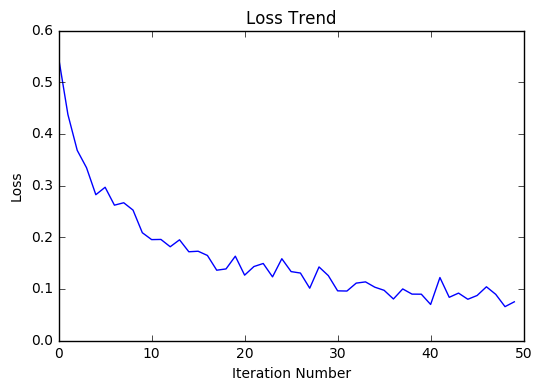

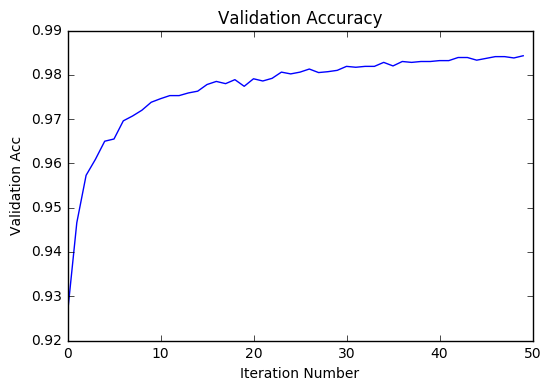

In [52]:
import matplotlib.pyplot as plt

plt.title("Loss Trend")
plt.plot(l)
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.show()

plt.title("Validation Accuracy")
plt.plot(a)
plt.xlabel('Iteration Number')
plt.ylabel('Validation Acc')
plt.show()

In [53]:
nn.predict(testX, testY)

0.9829

In [54]:
f = open("model-2.pkl", "wb")
pkl.dump(nn.params, f)
f.close()

In [55]:
g = open("model-2.pkl", "rb")
ps = pkl.load(g)
g.close()